## Assignment 2: Scoring New House Price Data

In [1]:
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt

# for the yeo-johnson transformation
import scipy.stats as stats

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# to save the model
import joblib

In [2]:
train_data = pd.read_csv('train.csv')
# load the unseen / new dataset
data = pd.read_csv('test.csv')

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [3]:
# drop id, it is just a number given to identify each house
data.drop('Id', axis=1, inplace=True)

data.shape

(1459, 79)

### Fill categorical variables

In [4]:
# let's identify the categorical variables
# we will capture those of type *object*

cat_vars = [var for var in data.columns if data[var].dtype == 'O']

# MSSubClass is also categorical by definition, despite its numeric values
# (you can find the definitions of the variables in the data_description.txt
# file available on Kaggle, in the same website where you downloaded the data)

# lets add MSSubClass to the list of categorical variables
cat_vars = cat_vars + ['MSSubClass']

# number of categorical variables
len(cat_vars)

44

In [5]:
# cast all variables as categorical
data[cat_vars] = data[cat_vars].astype('O')
train_data[cat_vars] = train_data[cat_vars].astype('O')

In [6]:
# now let's identify the numerical variables

num_vars = [
    var for var in data.columns if var not in cat_vars]

# number of numerical variables
len(num_vars)

35

In [7]:
# make a list of the variables that contain missing values
cat_vars_with_na = [
    var for var in cat_vars
    if data[var].isnull().sum() > 0
]

# determine percentage of missing values (expressed as decimals)
# and display the result ordered by % of missin data

data[cat_vars_with_na].isnull().mean().sort_values(ascending=False)

PoolQC          0.997944
MiscFeature     0.965045
Alley           0.926662
Fence           0.801234
FireplaceQu     0.500343
GarageCond      0.053461
GarageQual      0.053461
GarageFinish    0.053461
GarageType      0.052090
BsmtCond        0.030843
BsmtQual        0.030158
BsmtExposure    0.030158
BsmtFinType1    0.028787
BsmtFinType2    0.028787
MasVnrType      0.010966
MSZoning        0.002742
Functional      0.001371
Utilities       0.001371
KitchenQual     0.000685
Exterior2nd     0.000685
Exterior1st     0.000685
SaleType        0.000685
dtype: float64

In [8]:
# variables to impute with the string missing
with_string_missing = [var for var in cat_vars_with_na if data[var].isnull().mean() > 0.1]

# variables to impute with the most frequent category
with_frequent_category = [var for var in cat_vars_with_na if data[var].isnull().mean() < 0.1]

In [9]:
with_string_missing

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [10]:
data[with_string_missing] = data[with_string_missing].fillna('Missing')

In [11]:
for var in with_frequent_category:
    
    # there can be more than 1 mode in a variable
    # we take the first one with [0]    
    mode = data[var].mode()[0]
    
    print(var, mode)
    
    data[var].fillna(mode, inplace=True)

MSZoning RL
Utilities AllPub
Exterior1st VinylSd
Exterior2nd VinylSd
MasVnrType None
BsmtQual TA
BsmtCond TA
BsmtExposure No
BsmtFinType1 GLQ
BsmtFinType2 Unf
KitchenQual TA
Functional Typ
GarageType Attchd
GarageFinish Unf
GarageQual TA
GarageCond TA
SaleType WD


### Fill numeric variables

In [12]:
# make a list with the numerical variables that contain missing values
vars_with_na = [
    var for var in num_vars
    if data[var].isnull().sum() > 0
]

# print percentage of missing values per variable
data[vars_with_na].isnull().mean()

LotFrontage     0.155586
MasVnrArea      0.010281
BsmtFinSF1      0.000685
BsmtFinSF2      0.000685
BsmtUnfSF       0.000685
TotalBsmtSF     0.000685
BsmtFullBath    0.001371
BsmtHalfBath    0.001371
GarageYrBlt     0.053461
GarageCars      0.000685
GarageArea      0.000685
dtype: float64

In [13]:
# replace missing values as we described above

for var in vars_with_na:

    # calculate the mean
    mean_val = data[var].mean()
    
    print(var, mean_val)

    # add binary missing indicator
    data[var + '_na'] = np.where(data[var].isnull(), 1, 0)

    # replace missing values by the mean
    data[var].fillna(mean_val, inplace=True)

# check that we have no more missing values in the engineered variables
data[vars_with_na].isnull().sum()

LotFrontage 68.58035714285714
MasVnrArea 100.70914127423822
BsmtFinSF1 439.2037037037037
BsmtFinSF2 52.61934156378601
BsmtUnfSF 554.2949245541838
TotalBsmtSF 1046.1179698216736
BsmtFullBath 0.4344543582704187
BsmtHalfBath 0.06520247083047358
GarageYrBlt 1977.7212165097756
GarageCars 1.7661179698216736
GarageArea 472.76886145404666


LotFrontage     0
MasVnrArea      0
BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
BsmtFullBath    0
BsmtHalfBath    0
GarageYrBlt     0
GarageCars      0
GarageArea      0
dtype: int64

### Temporal variables

In [14]:
def elapsed_years(df, var):
    # capture difference between the year variable
    # and the year in which the house was sold
    df[var] = df['YrSold'] - df[var]
    return df

In [15]:
year_vars = [var for var in num_vars if 'Yr' in var or 'Year' in var]

year_vars

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

In [16]:
for var in year_vars:
    print(var, data[var].unique())
    print()

YearBuilt [1961 1958 1997 1998 1992 1993 1990 1970 1999 1971 1975 2009 2005 2003
 2002 2006 2004 1920 1974 2000 2010 1967 1978 1966 1964 1962 1952 1949
 1959 1956 1955 1948 1960 1963 1900 1957 1938 1923 1890 1910 1922 1950
 1925 1939 1940 1942 1936 1930 1915 1912 1917 1907 1968 1977 1927 1947
 1954 1987 1996 1972 1945 1924 1931 1941 1994 1989 1921 1896 1976 2008
 1965 1973 1984 1985 1991 1969 1995 1980 2007 1986 1981 1951 1953 1935
 1902 1946 1934 1983 1880 1979 2001 1916 1918 1988 1937 1905 1928 1926
 1929 1914 1895 1982 1879 1901 1919 1932]

YearRemodAdd [1961 1958 1998 1992 1994 2007 1990 1970 1999 1971 1975 2010 2005 2006
 2004 2002 1950 1993 2000 2003 1967 1978 1966 1964 2001 2008 2009 1959
 1956 1952 1955 1960 1984 1954 1957 1962 1997 1980 1968 1987 1979 1996
 1972 1985 1991 1989 1977 1976 1973 1986 1969 1995 1974 1981 1965 1951
 1953 1963 1982 1988 1983]

GarageYrBlt [1961.         1958.         1997.         1998.         1992.
 1993.         1990.         1970.         1999.  

In [17]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    data = elapsed_years(data, var)

In [18]:
data.drop(['YrSold'], axis=1, inplace=True)

### Variable Transformation

In [19]:
num_vars = [
    var for var in data.columns if var not in cat_vars]

In [20]:
#  let's male a list of discrete variables
discrete_vars = [var for var in num_vars if len(
    data[var].unique()) < 20 and var not in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']]


print('Number of discrete variables: ', len(discrete_vars))

Number of discrete variables:  26


In [21]:
cont_vars = [
    var for var in num_vars if var not in discrete_vars+year_vars]

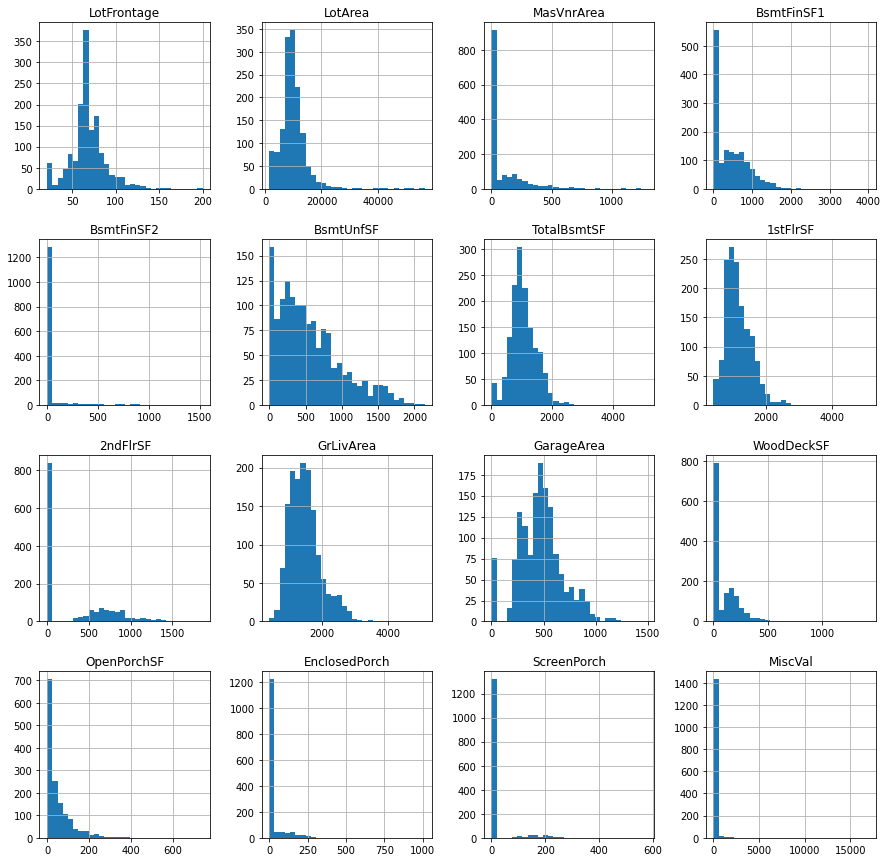

In [22]:
data[cont_vars].hist(bins=30, figsize=(15,15))
plt.show()

#### Log Transforms

In [23]:
for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]:
    data[var] = np.log(data[var])

In [24]:
[var for var in ["LotFrontage", "1stFlrSF", "GrLivArea"] if data[var].isnull().sum() > 0]

[]

#### Yeo Johnson Transforms

In [25]:
# the yeo-johnson transformation learns the best exponent to transform the variable
# it needs to learn it from the train set: 
data['LotArea'], param = stats.yeojohnson(data['LotArea'])

In [26]:
# check absence of na in the train set
[var for var in data.columns if data[var].isnull().sum() > 0]

[]

####  Binarize skewed variables
There were a few variables very skewed, we would transform those into binary variables.

In [27]:
skewed = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
]

for var in skewed:
    
    # map the variable values into 0 and 1
    data[var] = np.where(data[var]==0, 0, 1)

#### Apply mappings to categorials

In [28]:
# re-map strings to numbers, which determine quality

qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
             'HeatingQC', 'KitchenQual', 'FireplaceQu',
             'GarageQual', 'GarageCond',
            ]

for var in qual_vars:
    data[var] = data[var].map(qual_mappings)

In [29]:
exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

var = 'BsmtExposure'

data[var] = data[var].map(exposure_mappings)

In [30]:
finish_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

finish_vars = ['BsmtFinType1', 'BsmtFinType2']

for var in finish_vars:
    data[var] = data[var].map(finish_mappings)

In [31]:
garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

var = 'GarageFinish'

data[var] = data[var].map(garage_mappings)

In [32]:
fence_mappings = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

var = 'Fence'

data[var] = data[var].map(fence_mappings)

In [33]:
# check absence of na in the train set
[var for var in data.columns if data[var].isnull().sum() > 0]

[]

#### Removing Rare Labels

In [34]:
# capture all quality variables

qual_vars  = qual_vars + finish_vars + ['BsmtExposure','GarageFinish','Fence']

# capture the remaining categorical variables
# (those that we did not re-map)

cat_others = [
    var for var in cat_vars if var not in qual_vars
]

len(cat_others)

30

In [35]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset

    df = df.copy()

    tmp = df.groupby(var)[var].count() / len(df)

    return tmp[tmp > rare_perc].index


for var in cat_others:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(train_data, var, 0.01)
    
    print(var, frequent_ls)
    print()
    
    # replace rare categories by the string "Rare"
    train_data[var] = np.where(train_data[var].isin(
        frequent_ls), train_data[var], 'Rare')
    
    data[var] = np.where(data[var].isin(
        frequent_ls), data[var], 'Rare')

MSZoning Index(['FV', 'RH', 'RL', 'RM'], dtype='object', name='MSZoning')

Street Index(['Pave'], dtype='object', name='Street')

Alley Index(['Grvl', 'Pave'], dtype='object', name='Alley')

LotShape Index(['IR1', 'IR2', 'Reg'], dtype='object', name='LotShape')

LandContour Index(['Bnk', 'HLS', 'Low', 'Lvl'], dtype='object', name='LandContour')

Utilities Index(['AllPub'], dtype='object', name='Utilities')

LotConfig Index(['Corner', 'CulDSac', 'FR2', 'Inside'], dtype='object', name='LotConfig')

LandSlope Index(['Gtl', 'Mod'], dtype='object', name='LandSlope')

Neighborhood Index(['Blmngtn', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor',
       'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NWAmes',
       'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW',
       'Somerst', 'StoneBr', 'Timber'],
      dtype='object', name='Neighborhood')

Condition1 Index(['Artery', 'Feedr', 'Norm', 'PosN', 'RRAn'], dtype='object', name='Condition1')

Condition2 Ind

#### Encoding of categorical variables

In [36]:
def replace_categories(train, test, var, target):
    
    # order the categories in a variable from that with the lowest
    # house sale price, to that with the highest
    ordered_labels = train.groupby([var])[target].mean().sort_values().index

    # create a dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}
    
    print(var, ordinal_label)
    print()

    # use the dictionary to replace the categorical strings by integers
    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)

In [37]:
for var in cat_others:
    replace_categories(train_data, data, var, 'SalePrice')

MSZoning {'Rare': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4}

Street {'Rare': 0, 'Pave': 1}

Alley {'Grvl': 0, 'Pave': 1, 'Rare': 2}

LotShape {'Reg': 0, 'IR1': 1, 'Rare': 2, 'IR2': 3}

LandContour {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3}

Utilities {'Rare': 0, 'AllPub': 1}

LotConfig {'Inside': 0, 'FR2': 1, 'Corner': 2, 'Rare': 3, 'CulDSac': 4}

LandSlope {'Gtl': 0, 'Mod': 1, 'Rare': 2}

Neighborhood {'MeadowV': 0, 'IDOTRR': 1, 'BrDale': 2, 'BrkSide': 3, 'Edwards': 4, 'OldTown': 5, 'Sawyer': 6, 'SWISU': 7, 'NAmes': 8, 'Mitchel': 9, 'SawyerW': 10, 'NWAmes': 11, 'Rare': 12, 'Gilbert': 13, 'Blmngtn': 14, 'CollgCr': 15, 'Crawfor': 16, 'ClearCr': 17, 'Somerst': 18, 'Timber': 19, 'StoneBr': 20, 'NridgHt': 21, 'NoRidge': 22}

Condition1 {'Artery': 0, 'Feedr': 1, 'Rare': 2, 'RRAn': 3, 'Norm': 4, 'PosN': 5}

Condition2 {'Rare': 0, 'Norm': 1}

BldgType {'2fmCon': 0, 'Duplex': 1, 'Twnhs': 2, 'TwnhsE': 3, '1Fam': 4}

HouseStyle {'SFoyer': 0, '1.5Fin': 1, 'Rare': 2, 'SLvl': 3, '1Story': 4, '2Story': 5

In [45]:
data[]

KeyError: "['YrSold', 'Id', 'SalePrice'] not in index"

In [40]:
train_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

#### Feature Scaling

In [48]:
columns = ['MSSubClass',
            'MSZoning',
            'LotFrontage',
            'LotArea',
            'Street',
            'Alley',
            'LotShape',
            'LandContour',
            'Utilities',
            'LotConfig',
            'LandSlope',
            'Neighborhood',
            'Condition1',
            'Condition2',
            'BldgType',
            'HouseStyle',
            'OverallQual',
            'OverallCond',
            'YearBuilt',
            'YearRemodAdd',
            'RoofStyle',
            'RoofMatl',
            'Exterior1st',
            'Exterior2nd',
            'MasVnrType',
            'MasVnrArea',
            'ExterQual',
            'ExterCond',
            'Foundation',
            'BsmtQual',
            'BsmtCond',
            'BsmtExposure',
            'BsmtFinType1',
            'BsmtFinSF1',
            'BsmtFinType2',
            'BsmtFinSF2',
            'BsmtUnfSF',
            'TotalBsmtSF',
            'Heating',
            'HeatingQC',
            'CentralAir',
            'Electrical',
            '1stFlrSF',
            '2ndFlrSF',
            'LowQualFinSF',
            'GrLivArea',
            'BsmtFullBath',
            'BsmtHalfBath',
            'FullBath',
            'HalfBath',
            'BedroomAbvGr',
            'KitchenAbvGr',
            'KitchenQual',
            'TotRmsAbvGrd',
            'Functional',
            'Fireplaces',
            'FireplaceQu',
            'GarageType',
            'GarageYrBlt',
            'GarageFinish',
            'GarageCars',
            'GarageArea',
            'GarageQual',
            'GarageCond',
            'PavedDrive',
            'WoodDeckSF',
            'OpenPorchSF',
            'EnclosedPorch',
            '3SsnPorch',
            'ScreenPorch',
            'PoolArea',
            'PoolQC',
            'Fence',
            'MiscFeature',
            'MiscVal',
            'MoSold',
            'SaleType',
            'SaleCondition',
            'LotFrontage_na',
            'MasVnrArea_na',
            'GarageYrBlt_na']

In [49]:
scaler = joblib.load('minmax_scaler.joblib') 

data = pd.DataFrame(
    scaler.transform(data[columns]),
    columns=data[columns].columns
)

#### Select the features for prediction

In [50]:
features = pd.read_csv('selected_features.csv')
features = features['0'].to_list() 

# display final feature set
features

['MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotShape',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'OverallQual',
 'OverallCond',
 'YearRemodAdd',
 'RoofStyle',
 'Exterior1st',
 'ExterQual',
 'Foundation',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinType1',
 'HeatingQC',
 'CentralAir',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'HalfBath',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'PavedDrive',
 'WoodDeckSF',
 'ScreenPorch',
 'SaleCondition']

In [51]:
data = data[features]

In [52]:
lin_model = joblib.load('linear_regression.joblib')

In [53]:
# make predictions for test set
pred = lin_model.predict(data)

In [54]:
print('Average house price: ', int(np.median(np.exp(pred))))

Average house price:  159497
